In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os


import Libraries.dataloader as dl
import segmentation_models_pytorch as smp

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random

from Libraries.unet3d import UNet

import os
from PIL import Image
from IPython.display import display
import open3d as o3d

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Functions 
def CreatePointCloud(color_im, depth_im):
    color_raw = o3d.geometry.Image(np.uint8(color_im))
    depth_raw = o3d.geometry.Image(np.float32(depth_im))
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw, 1000) # 
    PointCloud = o3d.geometry.PointCloud.create_from_rgbd_image(
      rgbd_image,o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)) # Creates Point Cloud from rgbd image
#     PointCloud.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]) # Flip it, otherwise the pointcloud will be upside down
    return PointCloud

def CreateAxisCloud(depth_im):
    depth_raw  = o3d.geometry.Image(np.float32(depth_im/1)) # Converts depth data into image format
    PointCloud = o3d.geometry.PointCloud.create_from_depth_image(depth_raw,o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
    # PointCloud.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]) # Flip it, otherwise the pointcloud will be upside down
    return PointCloud

def pick_points(pcd):
    vis = o3d.visualization.VisualizerWithEditing()
    vis.create_window()
    vis.add_geometry(pcd)
    vis.run()
    vis.destroy_window()
    numpy_array=np.asarray(pcd.points)
    point_id=vis.get_picked_points()

    return [numpy_array[point_id[0]],numpy_array[point_id[1]]]

def draw_arrow(pcd, points_real, points_extimated):
    lines=[[0,1],[2,3]]
    points = np.concatenate((points_real, points_extimated), axis=0)
    colors = [[1,0,0],[0,1,0]] # Red is REAL and Green is ESTIMATED
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(points),
        lines=o3d.utility.Vector2iVector(lines),

    )
    line_set.colors=o3d.utility.Vector3dVector(colors)
    o3d.visualization.draw_geometries([pcd,line_set])

In [3]:
# Transformations

class GaussianNoise(object):
    def __init__(self, p=0.5, mean=[0.0, 0.5], std=[1.0, 1.0]):
        self.p    = p
        self.std  = np.random.uniform(std[0],std[1])
        self.mean = np.random.uniform(mean[0],mean[1])
        
    def __call__(self, tensor):
        if random.random() < self.p:
            return tensor + torch.randn(tensor.size()) * self.std + self.mean
        else:
            return tensor 


DataAug = transforms.Compose([
    transforms.ColorJitter(
        brightness=[0.5,1.5],
        contrast=[0.5, 1.5],
        saturation=[0.5, 1.5],
        hue=[-0.1,0.1],
    ),
    transforms.GaussianBlur(
        kernel_size=3,
        sigma=(0.1, 9.0)
    ),
#     transforms.RandomErasing(
#         p=0.1,
#         scale=(0.01, 0.1),
#         ratio=(0.01, 3.3),
#         value=0,
#     ),
    GaussianNoise(
        p=0.2,
        mean=[0.0, 0.1],
        std=[0.01, 0.3]
    )
])

In [4]:
from Libraries.dataloader import DataLoader as DL

DATASET_ROOTDIR='/home/el_zlociako/Documents/Praca_inzynierska/Dataset/'
dl = DL()

X_A, y_A = dl.load(DATASET_ROOTDIR, 'files/data.csv', 'files/axis', 'S')
X_B, y_B = dl.load(DATASET_ROOTDIR, 'files_ArUco/data_ArUco.csv', 'files_ArUco/axis', 'S')

X_trainA, X_validationA, y_trainA, y_validationA = train_test_split(X_A, y_A, test_size=0.2, random_state=101)
X_trainB, X_validationB, y_trainB, y_validationB = train_test_split(X_B, y_B, test_size=0.03, random_state=101)

X_train = torch.cat((X_trainA, X_trainB),axis=0)
y_train = torch.cat((y_trainA, y_trainB),axis=0)

X_train_aug = X_train.clone()
for i in range(X_train_aug.shape[0]):
     X_train_aug[i] = DataAug(X_train_aug[i])
        
X_train = torch.cat((X_train, X_train_aug),axis=0)
y_train = torch.cat((y_train, y_train),axis=0)

X_validation = torch.cat((X_validationA, X_validationB),axis=0)
y_validation = torch.cat((y_validationA, y_validationB),axis=0)

In [5]:
y_train.shape

torch.Size([1002, 1, 256, 320])

In [6]:
train_set = TensorDataset(X_train, y_train)
val_set = TensorDataset(X_validation, y_validation)

loader_args = dict(batch_size=3, num_workers=os.cpu_count(), pin_memory=True, drop_last=True)
train_loader = DataLoader(train_set,shuffle=True, **loader_args)
val_loader = DataLoader(val_set,shuffle=False, **loader_args)

In [7]:
device='cuda'
Model= smp.Unet(in_channels=3, classes=1,encoder_weights=None,encoder_name='timm-resnest50d').to(device)
Model.load_state_dict(torch.load('Modele/Big_UN1_60Epoch.pt'))
Model.eval()

Unet(
  (encoder): ResNestEncoder(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResNestBottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [8]:
ModelCutter = smp.Unet(in_channels=4, classes=1, encoder_weights=None, encoder_name='timm-resnest50d').to(device)
# ModelCutter = UNet(n_channels=4, n_classes=1, width_multiplier=1, trilinear=True, use_ds_conv=False).to(device)

In [9]:
class InpaintLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, out, gt, mask):
        out = torch.mul(out, mask.view(out.shape))
        mask = torch.nonzero(mask.reshape(-1))
        
        loss = torch.sum(torch.abs(torch.subtract(out, gt)).view(-1))
        loss = torch.div(loss, mask.shape[0])

        return loss

In [10]:
criterion = nn.MSELoss()
# criterion = InpaintLoss()

optimizer = torch.optim.Adam(ModelCutter.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', patience=10, min_lr=0.0000001)

In [28]:
epochs = 43

train_losses = []
validation_losses = []

ModelCutter.train()

for epoch in range(epochs):
    for batch, (images, true_mask) in enumerate(train_loader):
        
        batch+=1
        new_conn = []
    #         Apply the model
        images = images.to(device=device)
        true_mask = true_mask.to(device=device)
        
        with torch.no_grad():
            seg_ax = Model(images) 
            seg_ax = F.threshold(seg_ax, 1, 0)
  
        images_connected = torch.cat((images, seg_ax), axis=1)
#         images_connected = images_connected.reshape(images_connected.shape[0],
#                                                     4, 64, 80, 16) # transofrmation for UNet3D
#         true_mask = true_mask.reshape(true_mask.shape[0],
#                                                     1, 64, 80, 16) # transofrmation for UNet3D
        mask_pred = ModelCutter(images_connected)
        loss = criterion(mask_pred,true_mask)     
#         loss = criterion(mask_pred,true_mask,seg_ax)

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        print(f'epoch: {epoch+1:2}  batch: {batch}  loss: {loss.item():10.8f}')

    train_losses.append(loss.cpu().detach().numpy())
    scheduler.step(loss)
# Run the validationing batches
    with torch.no_grad():
        for batch, (images, true_mask) in enumerate(val_loader):
            batch+=1
            
            images = images.to(device=device)
            true_mask = true_mask.to(device=device)

            with torch.no_grad():
                seg_ax = Model(images)
                seg_ax = F.threshold(seg_ax, 1, 0)
            
            images_connected = torch.cat((images, seg_ax), axis=1)
#             images_connected = images_connected.reshape(images_connected.shape[0],
#                                                     4, 64, 80, 16) # transofrmation for UNet3D
#             true_mask = true_mask.reshape(true_mask.shape[0],
#                                                     1, 64, 80, 16) # transofrmation for UNet3D
            
            mask_pred = ModelCutter(images_connected)
            loss = criterion(mask_pred,true_mask)  
#             loss = criterion(mask_pred,true_mask,seg_ax)

    validation_losses.append(loss.cpu().detach().numpy())

epoch:  1  batch: 1  loss: 0.00274417
epoch:  1  batch: 2  loss: 0.00067083
epoch:  1  batch: 3  loss: 0.00108515
epoch:  1  batch: 4  loss: 0.00065553
epoch:  1  batch: 5  loss: 0.00247479
epoch:  1  batch: 6  loss: 0.00114994
epoch:  1  batch: 7  loss: 0.00104324
epoch:  1  batch: 8  loss: 0.00134614
epoch:  1  batch: 9  loss: 0.00160311
epoch:  1  batch: 10  loss: 0.00090521
epoch:  1  batch: 11  loss: 0.00393372
epoch:  1  batch: 12  loss: 0.00111806
epoch:  1  batch: 13  loss: 0.00041810
epoch:  1  batch: 14  loss: 0.00071300
epoch:  1  batch: 15  loss: 0.00079802
epoch:  1  batch: 16  loss: 0.00178733
epoch:  1  batch: 17  loss: 0.00096232
epoch:  1  batch: 18  loss: 0.00134671
epoch:  1  batch: 19  loss: 0.00103748
epoch:  1  batch: 20  loss: 0.00032282
epoch:  1  batch: 21  loss: 0.00135685
epoch:  1  batch: 22  loss: 0.00116522
epoch:  1  batch: 23  loss: 0.00167397
epoch:  1  batch: 24  loss: 0.00064792
epoch:  1  batch: 25  loss: 0.00201709
epoch:  1  batch: 26  loss: 0.0005

KeyboardInterrupt: 

In [ ]:
plt.plot(train_losses, label='training loss')
plt.plot(validation_losses, label='validation loss')
plt.legend();
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [14]:
# Rename it !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# torch.save(ModelCutter.state_dict(), 'Modele/Big_UN2-60E.pt')

In [29]:
ModelCutter.load_state_dict(torch.load('Modele/Big_UN2-60E.pt'))
ModelCutter.eval()

Unet(
  (encoder): ResNestEncoder(
    (conv1): Sequential(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResNestBottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

# Check model

In [30]:
inv_resize = transforms.Resize([480,640], interpolation=transforms.InterpolationMode.NEAREST)

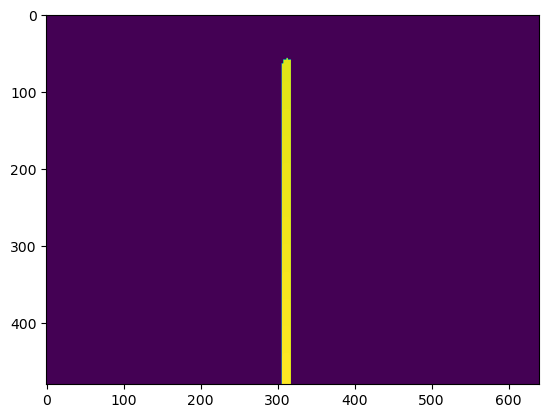

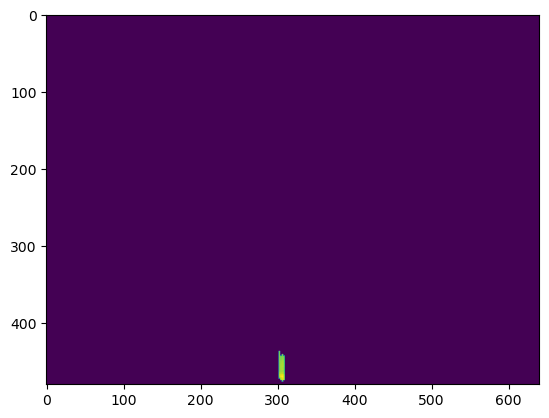

------------------------------------------------------------


KeyboardInterrupt: 

In [31]:
with torch.no_grad():
    for b, (images, true_mask) in enumerate(val_loader):
#         Apply the model
        images = images.to(device=device)
        true_mask = true_mask.to(device=device)
        
        seg_ax = Model(images)
        seg_ax = F.threshold(seg_ax, 0.2, 0)
        images_connected = torch.cat((images, seg_ax), axis=1)
#         images_connected = images_connected.reshape(images_connected.shape[0],
#                                                     4, 64, 80, 16) # transofrmation for UNet3D
#         true_mask = true_mask.reshape(true_mask.shape[0],
#                                                     1, 64, 80, 16) # transofrmation for UNet3D
        
        mask_pred = ModelCutter(images_connected)
        mask_pred = F.threshold(mask_pred, 1, 0)
        
        for j in range(mask_pred.shape[0]):
            images_buff = inv_resize(images[j])
            RGB_buff = images_buff[0].cpu().numpy()*255
#             print(RGB_buff.shape)
#             RGB_buff = np.transpose(RGB_buff, (1,2,0))
            RGB_buff = np.ascontiguousarray(RGB_buff, dtype=np.uint8)

            DEPTH_buff = images_buff[1].cpu().numpy()*5500
            trueAxis_buff = inv_resize(true_mask[j].reshape(1,256,320)).cpu().detach().numpy().transpose(1,2,0)
            predAxis_buff = inv_resize(mask_pred[j].reshape(1,256,320)).cpu().detach().numpy().transpose(1,2,0)
            
#             NEW_DEPTH = DEPTH_buff.reshape(DEPTH_buff.shape[0],DEPTH_buff.shape[1],1)
#             new_axis = np.zeros([480,640,1])
#             new_axis[np.where(predAxis_buff > 1)] = NEW_DEPTH[np.where(predAxis_buff > 1)]
            
#             minval = np.min(new_axis[np.nonzero(new_axis)])
#             new_axis[np.where(predAxis_buff > 1)] = minval
            
            PC_object = CreatePointCloud(RGB_buff, DEPTH_buff)
            PC_realAxis = CreateAxisCloud(trueAxis_buff)
            PC_predAxis = CreateAxisCloud(predAxis_buff)
#             DrawnAxis = CreateAxisCloud(new_axis/1000)
            
            o3d.visualization.draw_geometries([PC_object, PC_predAxis])

            plt.figure()
            plt.imshow(trueAxis_buff)
    
#             plt.figure()
#             plt.imshow(seg_ax[j].cpu().detach().numpy().transpose(1,2,0))
#             plt.show()
            
            plt.figure()
            plt.imshow(predAxis_buff)
            plt.show()
            print('------------------------------------------------------------')

# Foty do pracy

In [41]:
# aaa
Model.eval()
ModelCutter.eval()

num = 27
One_photo_x = X_validation[num].reshape(1,
                                      X_validation[num].shape[0],
                                      X_validation[num].shape[1],
                                      X_validation[num].shape[2]
                                     ).to(device)

One_photo_y = y_validation[num].reshape(1,
                                      y_validation[num].shape[0],
                                      y_validation[num].shape[1],
                                      y_validation[num].shape[2]
                                     ).to(device)

with torch.no_grad():
    seg2D = Model(One_photo_x)
    seg2D = F.threshold(seg2D, 1, 0)
    
    imag = torch.cat((One_photo_x, seg2D), axis=1)
    
    seg3D = ModelCutter(imag)
    seg3D = F.threshold(seg3D, 1, 0)

images_buff = inv_resize(One_photo_x[0])
RGB_buff = images_buff[0].cpu().numpy()*255
RGB_buff = np.ascontiguousarray(RGB_buff, dtype=np.uint8)

DEPTH_buff = images_buff[1].cpu().numpy()*5500
trueAxis_buff = inv_resize(seg2D[0]).cpu().detach().numpy().transpose(1,2,0)
predAxis_buff = inv_resize(seg3D[0]).cpu().detach().numpy().transpose(1,2,0)

#             NEW_DEPTH = DEPTH_buffq

def SaveFig(input, path, cmap=None):
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(input, aspect='auto',cmap=cmap)
    plt.show()
#     fig.savefig(path, format='png')

# SaveFig(images_buff[0].cpu().numpy(), 'Images/gray1.png', cmap='gray')
# SaveFig(images_buff[1].cpu().numpy(), 'Images/dep1.png')
# SaveFig(images_buff[2].cpu().numpy(), 'Images/dep12.png')
# SaveFig(seg2D[0].cpu().detach().numpy().transpose(1,2,0), 'Images/seg1.png')
# SaveFig(seg3D[0].cpu().detach().numpy().transpose(1,2,0), 'Images/test_seg.npy')
# np.save('Images/test_seg.npy', seg3D[0].cpu().detach().numpy().transpose(1,2,0))

# RANSAC

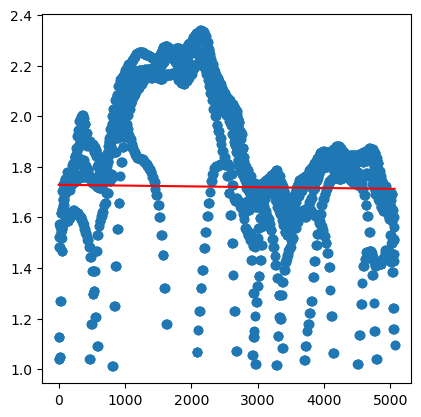

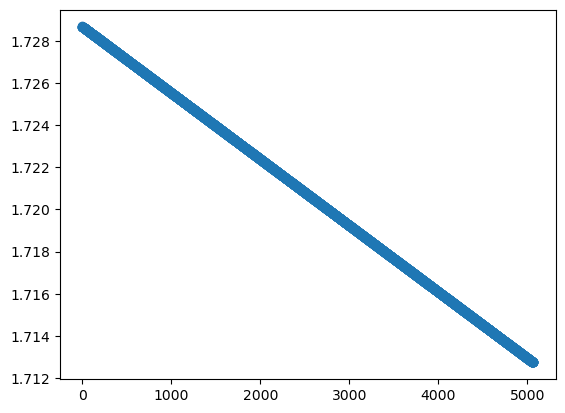

In [42]:
from Libraries import RANSAC


regressor = RANSAC.RANSAC(model=RANSAC.LinearRegressor(), 
                          loss=RANSAC.square_error_loss, 
                          metric=RANSAC.mean_square_error, )

test = inv_resize(seg3D[0]).cpu().detach().numpy().transpose(1,2,0)
elo = test.flatten()
elo = elo[np.nonzero(elo)]

t = np.arange(elo.shape[0])
X = t.reshape(-1,1)
y = elo.reshape(-1,1)
regressor.fit(X, y)

import matplotlib.pyplot as plt
# plt.style.use("seaborn-darkgrid")
fig, ax = plt.subplots(1, 1)
ax.set_box_aspect(1)

plt.scatter(X, y)

line = np.linspace(0, X.shape[0], num=X.shape[0]).reshape(-1, 1)

# test_complete = test_complete[np.nonzero(test_complete)].flatten().reshape(-1, 1)
test[np.nonzero(test)] = regressor.predict(line).reshape(1, -1)

plt.plot(line, regressor.predict(line), c="r")

elo1 = test.flatten()
elo1 = elo1[np.nonzero(elo1)]

plt.figure()
t1 = np.arange(elo1.shape[0])
plt.scatter(t1, elo1)
plt.show()

plt.show()


In [43]:
PC_object = CreatePointCloud(RGB_buff, DEPTH_buff)
PC_predAxis = CreateAxisCloud(test)

o3d.visualization.draw_geometries([PC_object,PC_predAxis])

KeyboardInterrupt: 